# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


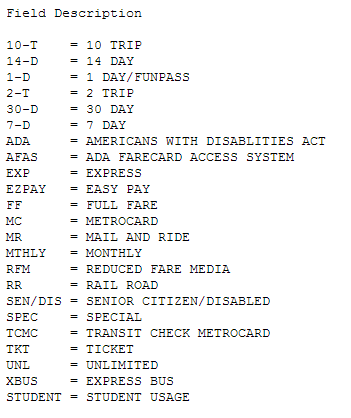

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
#!curl -O https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy
#!mv 'MTA_Fare.npy' $PUIDATA
mta= np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy")

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [5]:
mta = mta.astype('float')
mta [mta == -1] = np.nan
#There are 600 stations, 23 card types, contains the number of swipes per week for 194 weeks from 
stations = np.nansum(mta, axis=1)
print(stations.shape)
swipes_per_week = np.nansum(stations, axis=0)
print(swipes_per_week.shape)
card_type = np.nansum(mta, axis=0)
print(card_type.shape)

(600, 194)
(194,)
(23, 194)


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

(4, 6)

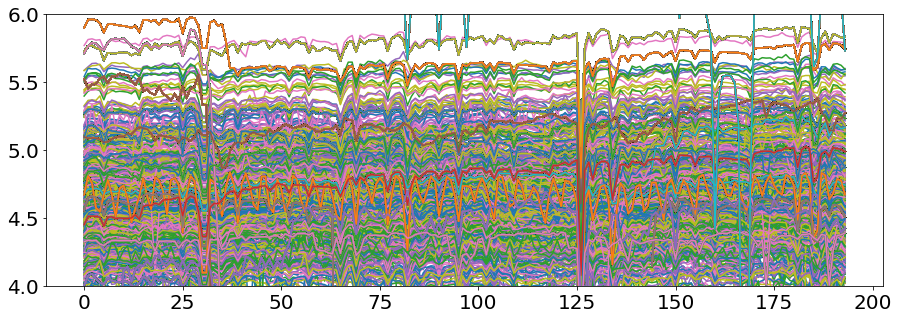

In [6]:
# plot the data in natural space
# then plot the data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

weeks = np.arange(194)
plt.figure(figsize = (15,5))
for i in range(0,600):
    plt.plot(weeks, np.log10(stations[i]))
    for i in range(0,23):
        plt.plot(weeks, np.log10(card_type[i]))
    
plt.ylim([4, 6])

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



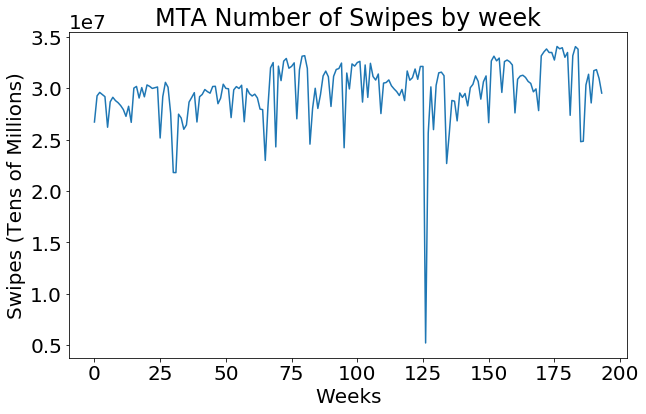

In [7]:
plt.figure(figsize=(10,6))
plt.plot(weeks, swipes_per_week)
plt.title('MTA Number of Swipes by week')
plt.xlabel('Weeks')
plt.ylabel('Swipes (Tens of Millions)')

The figure shows the MTA swips in tens of millions by week. There is a very significant drop of swipes between the 100th and the 150th weeks(around the 125th).

In [8]:
avg_swipes = np.nanmean(swipes_per_week)
std_swipes = np.nanstd(swipes_per_week)
print ("The mean of swipes per week is {:.3f}".format(avg_swipes))
print ("The std of swipes by week {:.3f}".format(std_swipes))
thresholds = [avg_swipes  - 3 * std_swipes, avg_swipes  + 3 * std_swipes]
print ("The 3 sigma thresholds of swipes by week are: {:.3f}, {:.3f}".format(*thresholds ))

The mean of swipes per week is 29781349.871
The std of swipes by week 2983960.422
The 3 sigma thresholds of swipes by week are: 20829468.606, 38733231.136


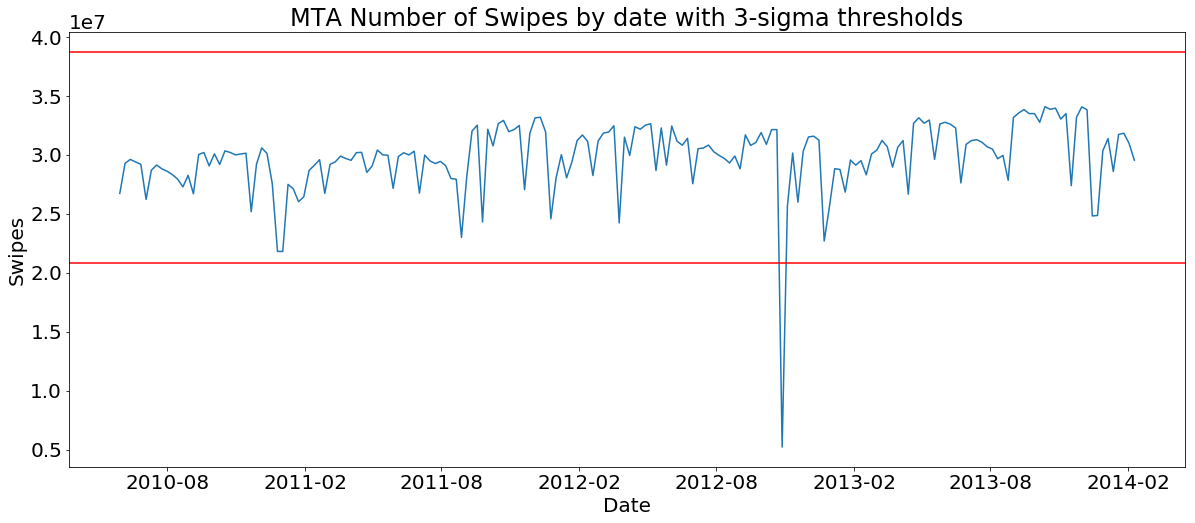

In [9]:
dates = pd.date_range(start='05/28/2010', periods=194, freq='W').date
plt.figure(figsize=(20,8))
plt.plot(dates, swipes_per_week)
axhline(y=thresholds[1],color='red')
axhline(y=thresholds[0],color='red')

plt.xlabel('Date', size=20)
plt.ylabel('Swipes', size=20)
plt.title('MTA Number of Swipes by date with 3-sigma thresholds', size=24)

The figure shows the MTA swipes in tens of millions by dates with the 3-sigma-thresholds(lower and upper) representing in red lines. There is no specific date that has swipes more than the upper threshold, but there is a date between 2012-08 and 2013-02 whose swipes is lower than the lower threshold.

In [10]:
#find the date that has the lowest swipes
date = dates[np.where(swipes_per_week < thresholds[0])]
print("The date that has a very significant drop(>3-sigma) of swipes is: %s" %date[0])

The date that has a very significant drop(>3-sigma) of swipes is: 2012-10-28


 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [11]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

ride_type = pd.DataFrame(card_type).T
ride_type.columns = ridetype
ride_type.head()   

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


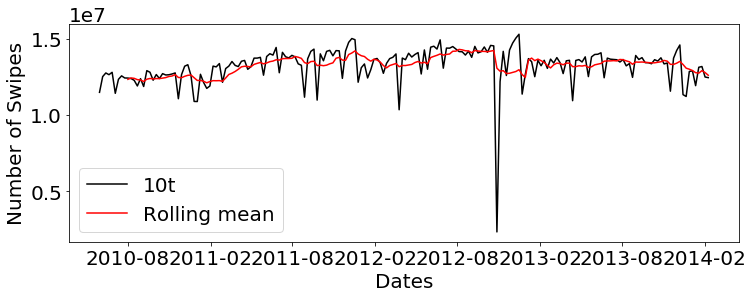

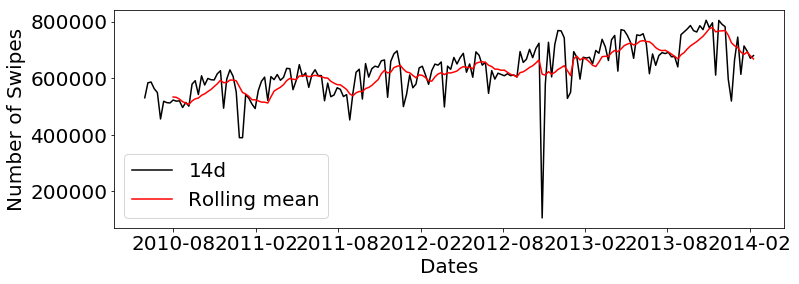

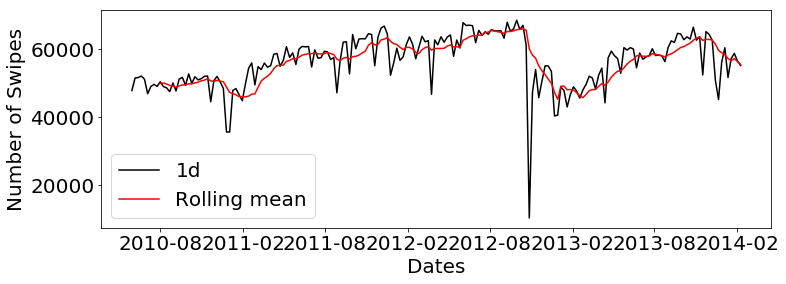

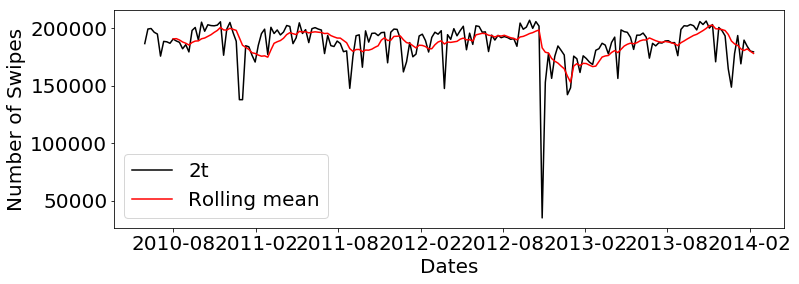

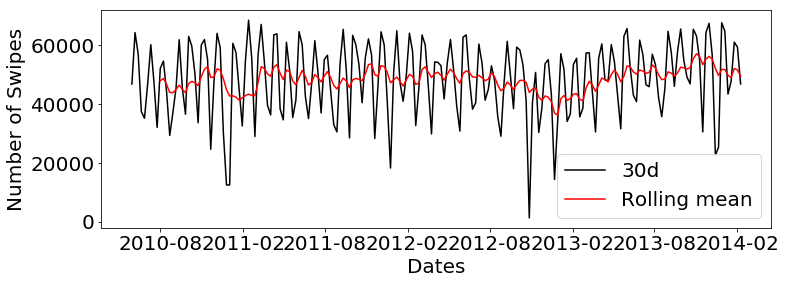

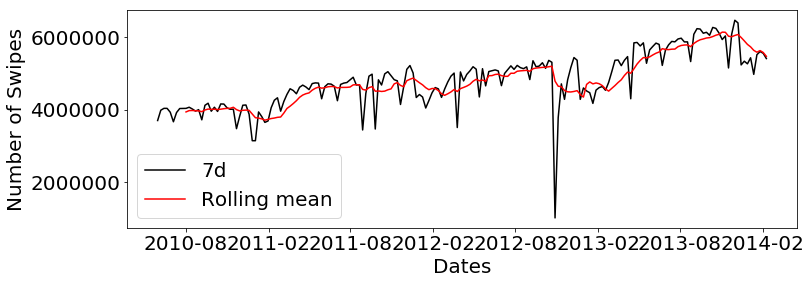

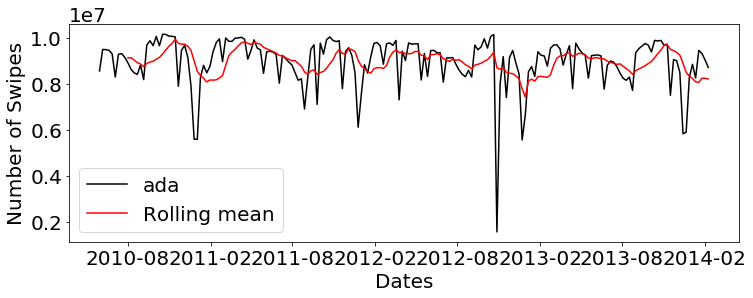

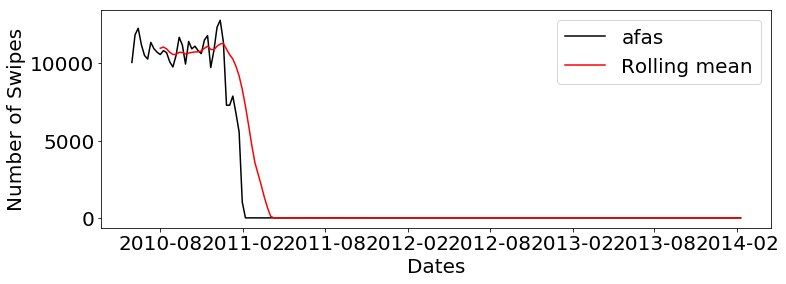

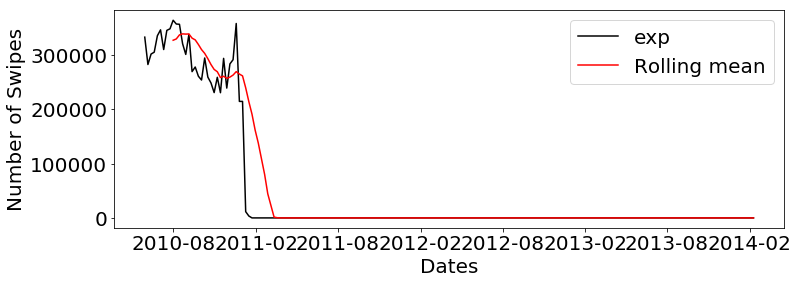

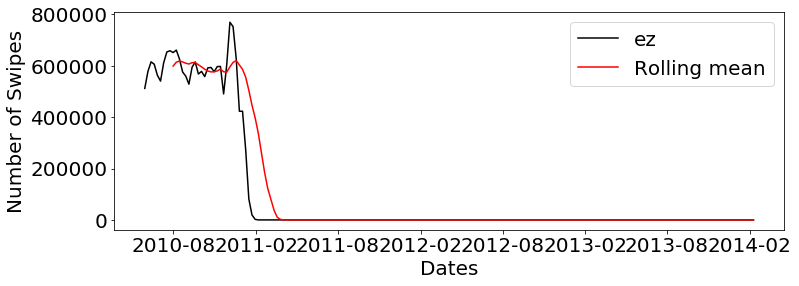

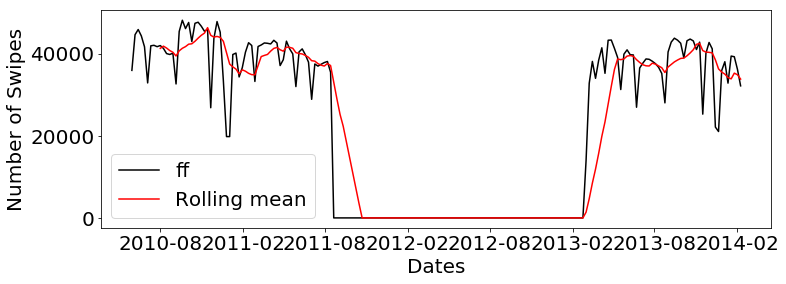

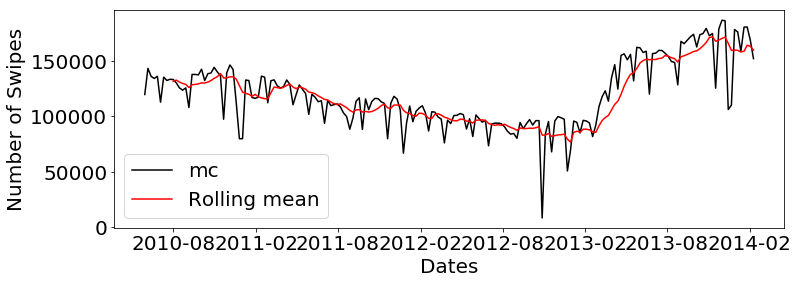

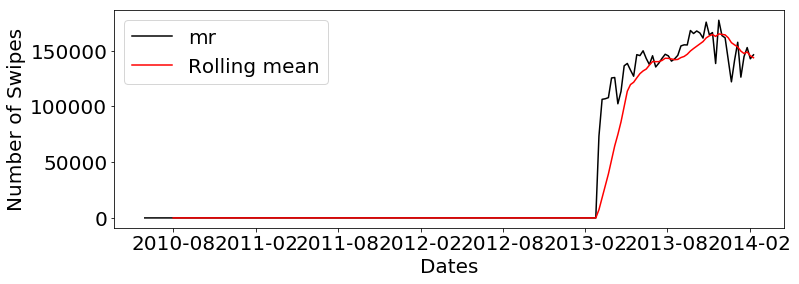

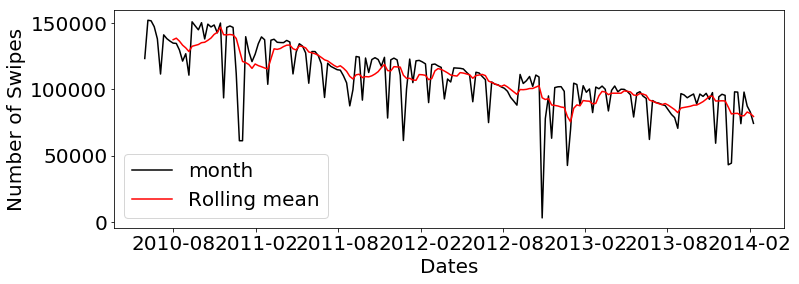

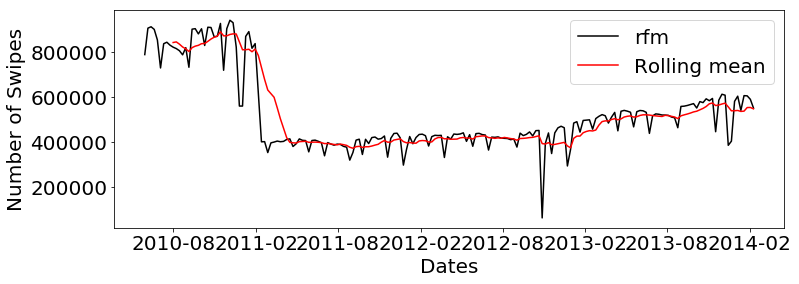

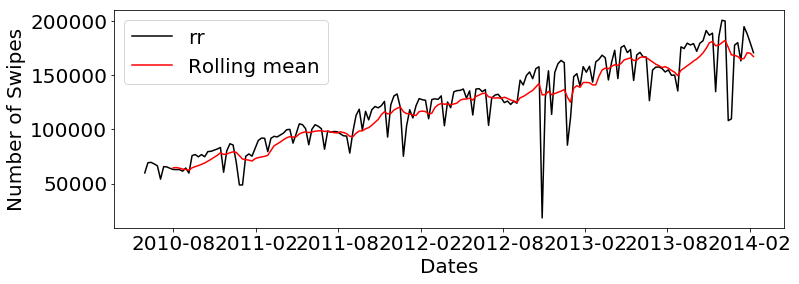

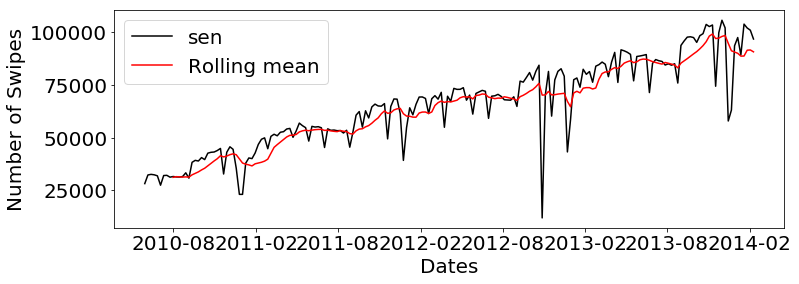

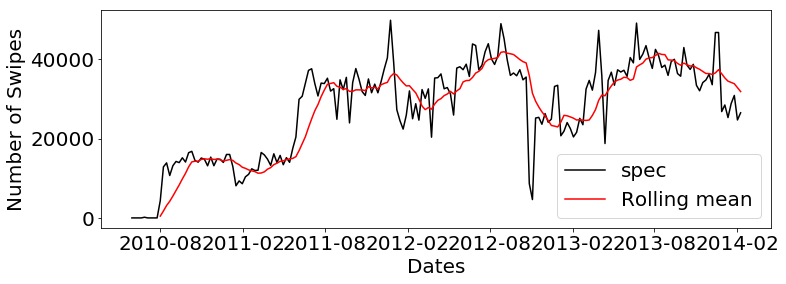

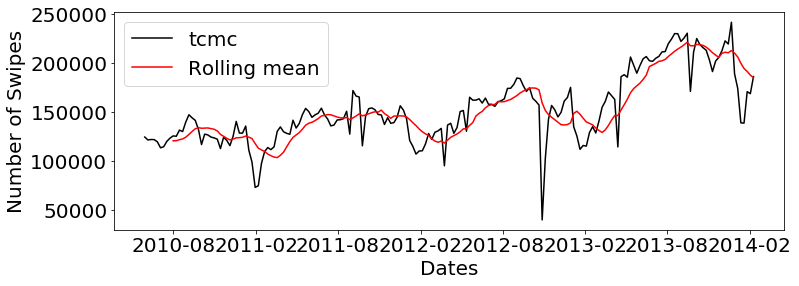

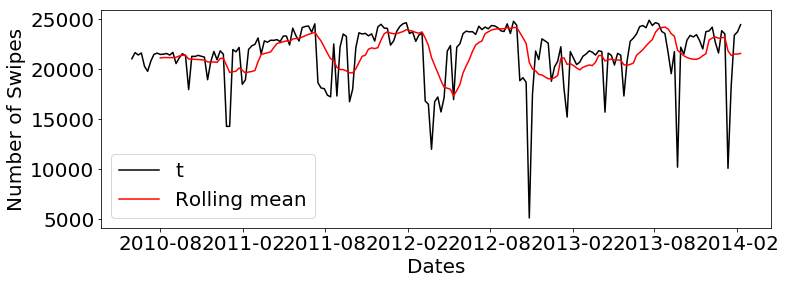

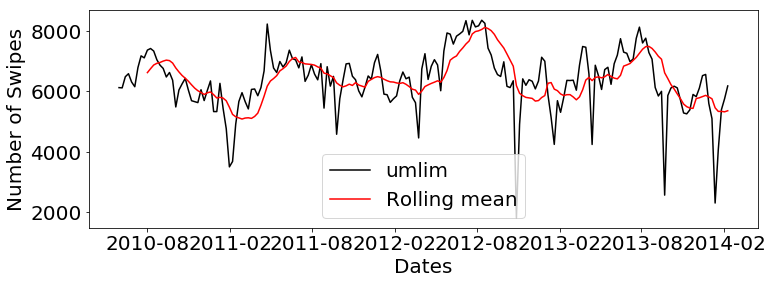

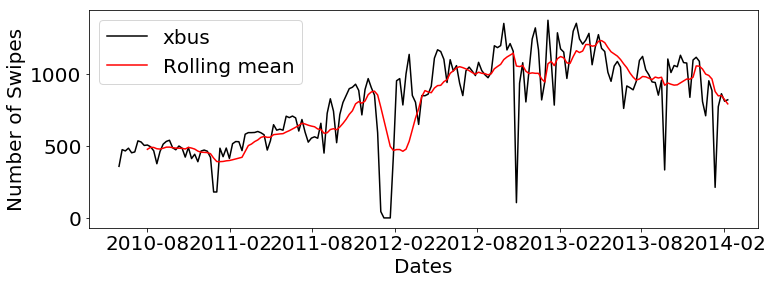

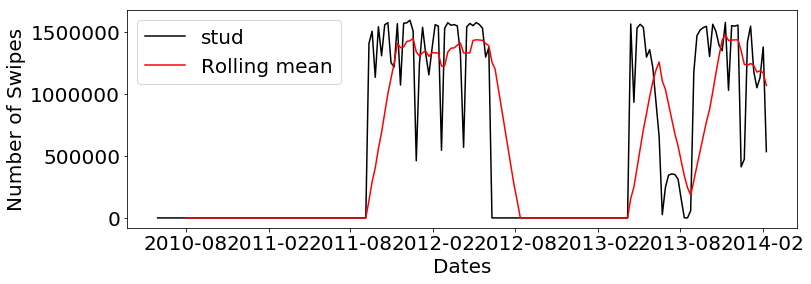

In [12]:
rolling_means = pd.DataFrame()
for i in ridetype:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    rolling_means[i] = pd.rolling_mean((ride_type[i]), 10)
    ax.plot(dates, ride_type[i], c='black', label=i)
    ax.legend(ridetype)
    ax.plot(dates, rolling_means[i], c='red',label='Rolling mean',)
    ax.legend()
    plt.xlabel("Dates")
    plt.ylabel("Number of Swipes")

The above figure plots the number of swipes with their smoothed rolling means for 23 rides type. We can see some trend for some ride types, for example, afas, exp, and ez, there is a significant drop of swipes after 2011 and it never rises again, probably because the types of cards have been canceled. ff card thas a significant drop to 0 between 2011 and 2013, and the number of swipes comes up to normal after.mr card does not have and swipes until 2013, and stud does not have swipes until 2011 and have a significant drop between 2012 and 2013. All other types of card have some smooth changes over time, but they are not constant trends.

In [13]:
ride_type = ride_type.dropna()
ratio_begining_end=[]
for i in ridetype:
    ratio_begining_end.append(pd.rolling_mean(ride_type[i], 10).head(10).mean()
                              /pd.rolling_mean(ride_type[i], 10).tail(10).mean())
# ratio_begining_end
ride_ratio= pd.DataFrame(zip(ridetype, ratio_begining_end), columns=['Ride Type', 'Begining to End Ratio'])
ride_ratio.sort(columns="Begining to End Ratio")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Ride Type,Begining to End Ratio
22,stud,0.000000
12,mr,0.000038
17,spec,0.013010
16,sen,0.340264
15,rr,0.379171
21,xbus,0.516228
18,tcmc,0.601154
5,7d,0.685982
1,14d,0.753057
11,mc,0.812340


In [14]:
# you should find the ride type that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend
steepest_decrease = ride_ratio.loc[ride_ratio['Begining to End Ratio'] == ride_ratio['Begining to End Ratio'].max()]
steepest_increase = ride_ratio.loc[ride_ratio['Begining to End Ratio'] == ride_ratio['Begining to End Ratio'].min()]
steepest_increase_1 = [steepest_increase['Ride Type'].values, steepest_increase['Begining to End Ratio'].values]
steepest_decrease_1 = [steepest_decrease['Ride Type'].values, steepest_decrease['Begining to End Ratio'].values]
print("The ride type that has the steepest increase is: %s." %steepest_increase_1[0][0])
print("Its ratio of the number of rides near the beginning to near the end of the time series is: %0.2f.\n" %steepest_increase_1[1][0])
print("The ride type that has the steepest decrease is: %s." %steepest_decrease_1[0][0])
print("Its ratio of the number of rides near the beginning to near the end of the time series is: %0.2f.\n" %steepest_decrease_1[1][0])


The ride type that has the steepest increase is: stud.
Its ratio of the number of rides near the beginning to near the end of the time series is: 0.00.

The ride type that has the steepest decrease is: ez.
Its ratio of the number of rides near the beginning to near the end of the time series is: 503545.13.



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


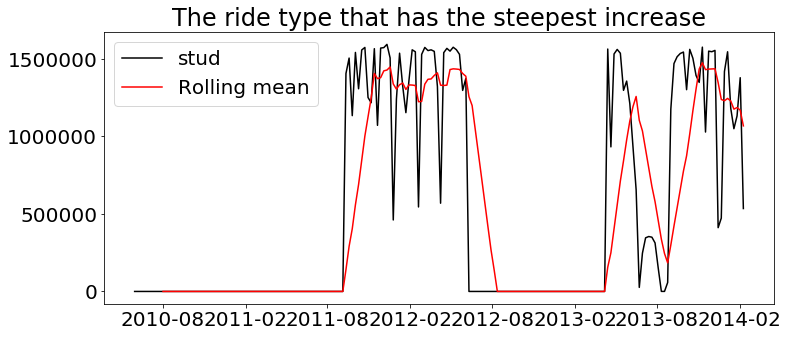

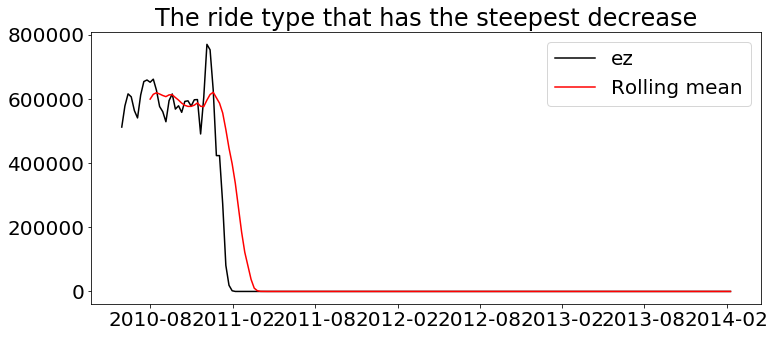

In [15]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
rolling_means['stud'] = pd.rolling_mean((ride_type['stud']), 10)
ax.plot(dates, ride_type['stud'], label="stud", c='black')
ax.legend()
ax.plot(dates, rolling_means['stud'], label='Rolling mean', c='red')
ax.set_title("The ride type that has the steepest increase")
ax.legend()

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
rolling_means['ez'] = pd.rolling_mean((ride_type['ez']), 10)
ax.plot(dates, ride_type['ez'], label="ez", c='black')
ax.legend()
ax.set_title("The ride type that has the steepest decrease")
ax.plot(dates, rolling_means['ez'], label='Rolling mean', c='red')
ax.legend()

The figure above shows the number of rides with their rolling mean for the ride types that has the steepest increase and decrease. It seems that the steepest increase for stud card coming from increase after a period of nonuse during 2012 and 2013, and the steepest decrease for es car is after 2011-02 when the card is been canceled.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [16]:
label = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        label.append(j)
        
label = np.array(label[:9317])    

label.shape


(9317,)

In [17]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [18]:
stationsmeans = np.nanmean(stations, axis=1)
stationsmeans.shape

(600,)

In [19]:
stationsstd  = np.nanstd(stations, axis=1)
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [20]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  2,   2,   2, ..., 550, 550, 550])

In [21]:
tots = mta.reshape(600*23,194)[:9317]
tots.shape

(9317, 194)

In [22]:
df = pd.DataFrame(tots)
normed_time_series_mean=[]
normed_time_series_std =[]
for i in range(tots.shape[0]):
    normed_time_series_mean.append(df.loc[i].mean() / stationsmeans[i//23]) ## asked Yiancheng Yin 
    normed_time_series_std.append(df.loc[i].std() / stationsstd[i//23])

In [23]:
normed_time_series_std[:10]

[0.48121740645950051,
 0.013844057327172572,
 0.0018026041196277476,
 0.0050723219448491333,
 0.003815476910230257,
 0.16078334654499601,
 0.27163128239996198,
 0.00050760790474932026,
 0.062718530495308414,
 0.026872094135176765]

In [24]:
tsmean = np.nanmean(tots, axis=1)
tsstdev = np.nanstd(tots, axis=1)
tsmean.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


(9317,)

In [25]:
tsmean[:10]

array([  5.85868854e+04,   1.82818229e+03,   2.37322917e+02,
         7.37656250e+02,   2.93140625e+02,   2.00333073e+04,
         3.05572969e+04,   8.57291667e+00,   9.77171875e+02,
         4.31281250e+02])

In [26]:
tsstdev[:10]

array([ 17761.09203889,    510.96567389,     66.53171155,    187.21263135,
          140.82415903,   5934.29867244,  10025.54800094,     18.7351301 ,
         2314.85723026,    991.81311982])

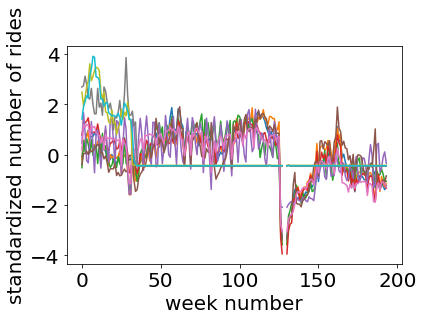

In [27]:
standardizedts = []
for i in range(9317):
    temp=[]
    temp.append((df.loc[i] - tsmean[i])/tsstdev[i])
    standardizedts.append(np.array(temp).reshape(194,))
standardizedts = np.array(standardizedts)

x=range(194)
for i in range(10):
    pl.plot(x,standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [28]:
index = []## asked Yiancheng Yin 
for i in range(0, len(standardizedts)):
    for j in range(0, len(standardizedts[i])):
        if np.isnan(standardizedts[i][j]):
            index.append(i)
index = np.unique(np.array(index))

X = []
Y = []
for i in range(0, len(standardizedts)):
    if i in index:
        continue
    else:
        Y.append(label[i])
        X.append(standardizedts[i])

In [29]:
# allfits = sm.OLS...
allfits = []
for i in range(len(X)):
    x = X[i]
    y = Y[i]
    md = sm.OLS([y], [x]).fit()
    allfits.append(md)
[a.params[0] for a in allfits[:10]]

[0.0,
 -0.0040890747697310686,
 -0.013858025912543382,
 0.016933803954919779,
 -0.014102884520797113,
 -0.029056070557372228,
 0.014461073894390244,
 -0.011370025784041391,
 0.11637390997154808,
 0.09944687579312135]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [30]:
a,b = tsmean/normed_time_series_mean, tsstdev/normed_time_series_std ## asked Yiancheng Yin 
normedtsmean = []
normedtsstd = []
for i in range(len(a)):
    if i in index:
        continue   
    else:
        normedtsmean.append(a[i])
        normedtsstd.append(b[i])

X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normedtsmean, normedtsstd]).T,
    Y, test_size=0.33, random_state=42, shuffle=True)

In [31]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((4531, 4), (2233, 4), (4531,), (2233,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [32]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [33]:
clf = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

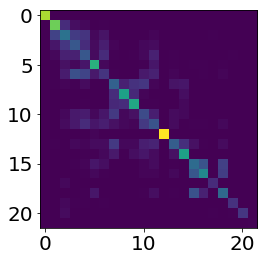

In [34]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [35]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.33, random_state=42, shuffle=True)

In [36]:
clf = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

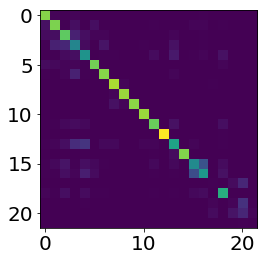

In [37]:
imshow(confusion_matrix(y_test, y_pred))

In [38]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.84      0.94      0.89       115
        14d       0.77      0.82      0.80       129
         1d       0.67      0.75      0.71       132
         2t       0.49      0.57      0.53       106
        30d       0.54      0.67      0.60       102
         7d       0.87      0.88      0.88       118
        ada       0.88      0.86      0.87       126
       afas       0.91      0.97      0.94       118
        exp       0.97      0.98      0.97       114
         ez       1.00      0.93      0.96       117
         ff       0.97      1.00      0.99       112
         mc       0.89      0.82      0.85       124
         mr       1.00      0.99      0.99       134
      month       0.69      0.57      0.62       134
        rfm       1.00      0.95      0.97       113
         rr       0.62      0.49      0.55       128
        sen       0.61      0.53      0.56       133
       spec       0.12      0.05      0.07   

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))
